In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 5
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 300
vmax = 1100
vmin = 980
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

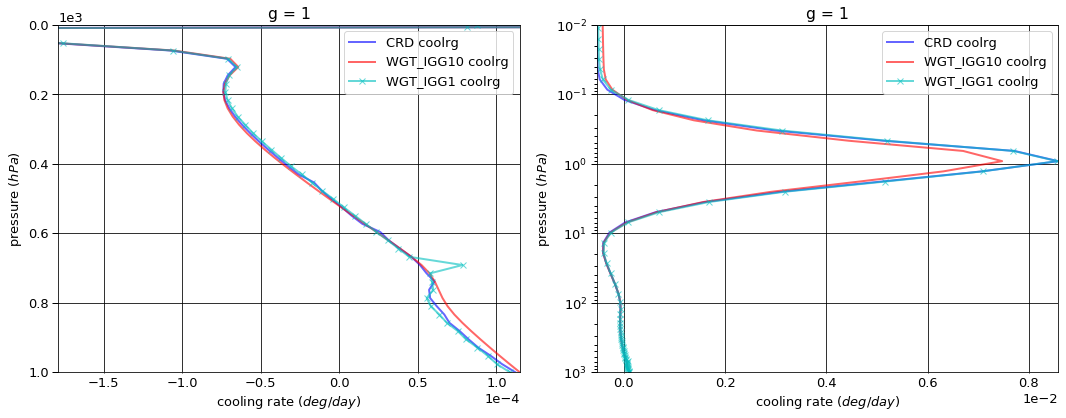

# Figure: cooling rate g-group 2

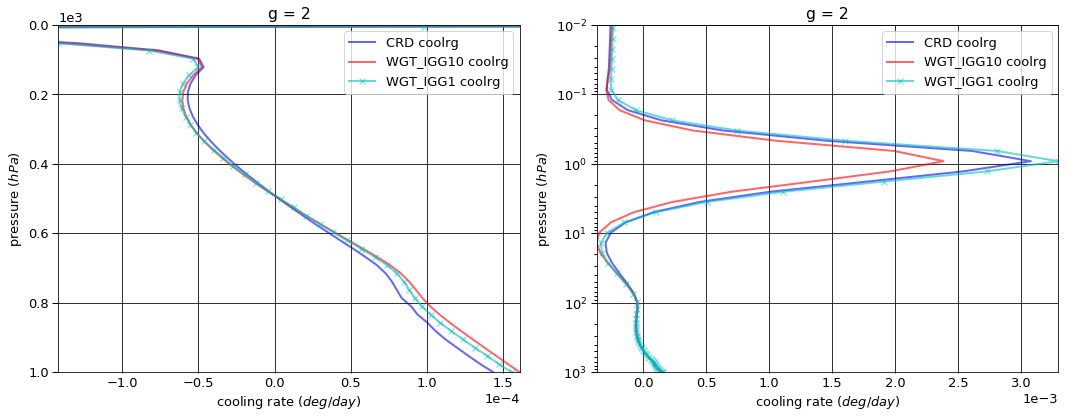

# Figure: cooling rate g-group 3

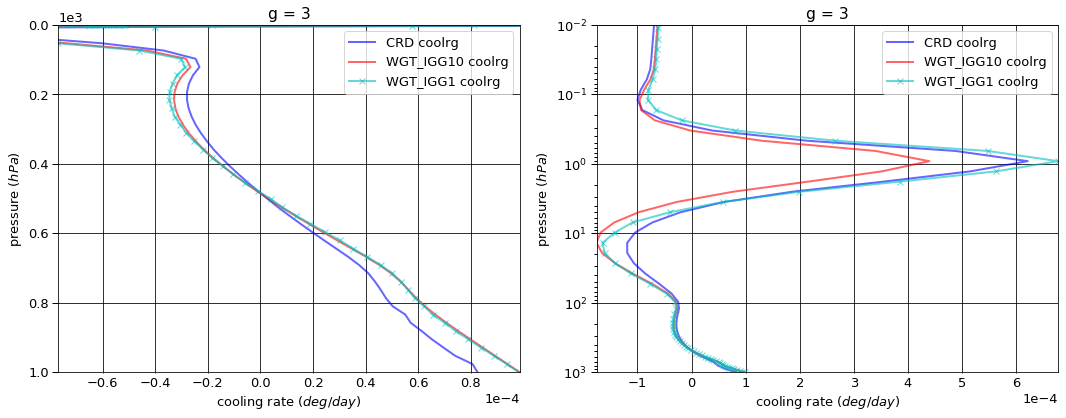

# Figure: cooling rate g-group 4

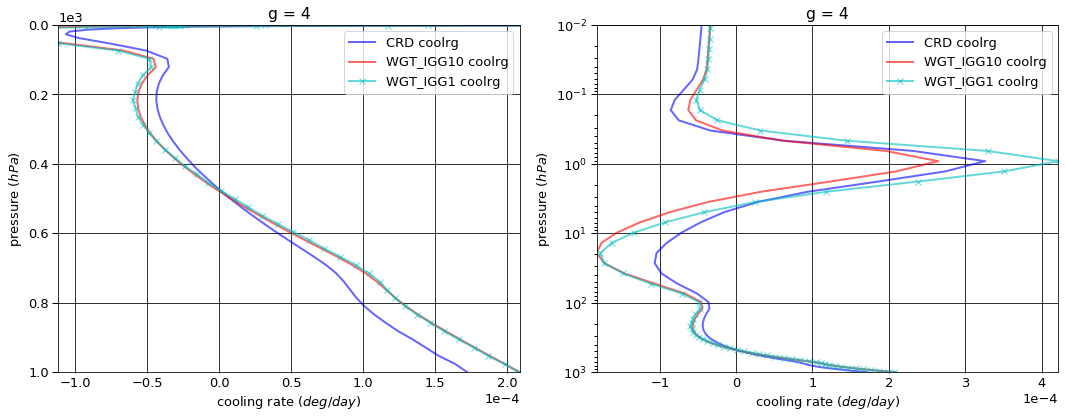

# Figure: cooling rate g-group 5

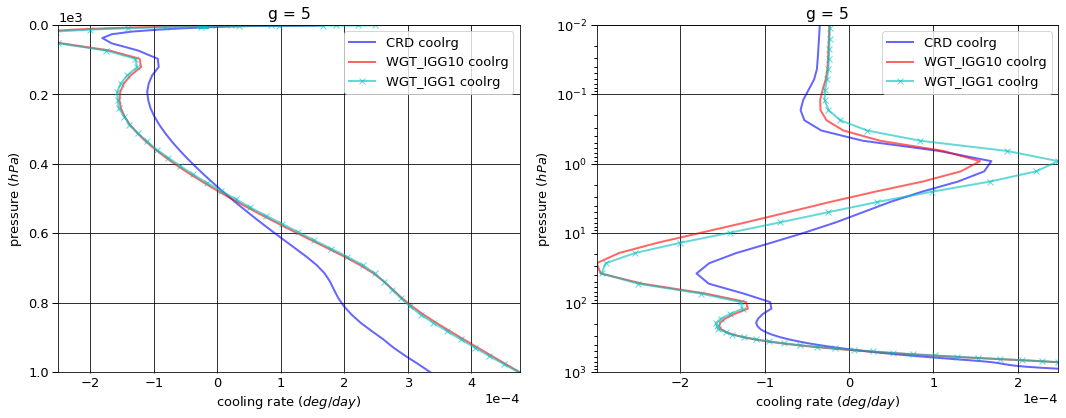

# Figure: cooling rate g-group 6

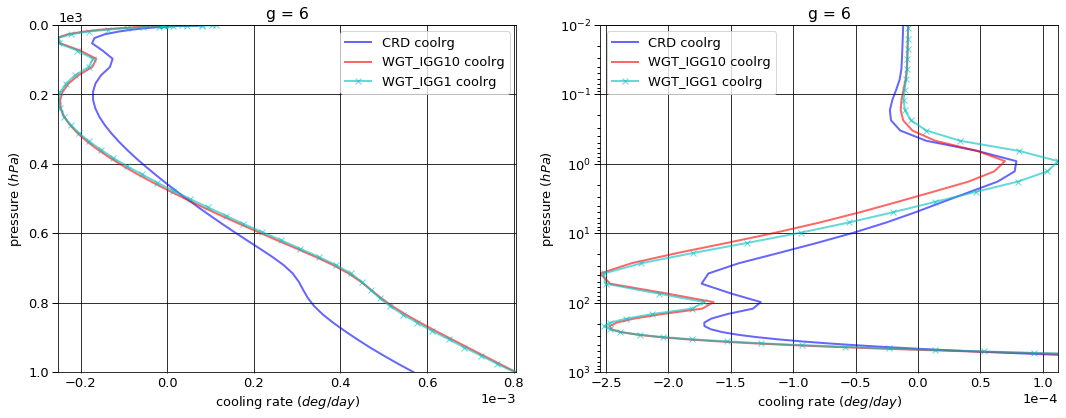

# Figure: cooling rate g-group 7

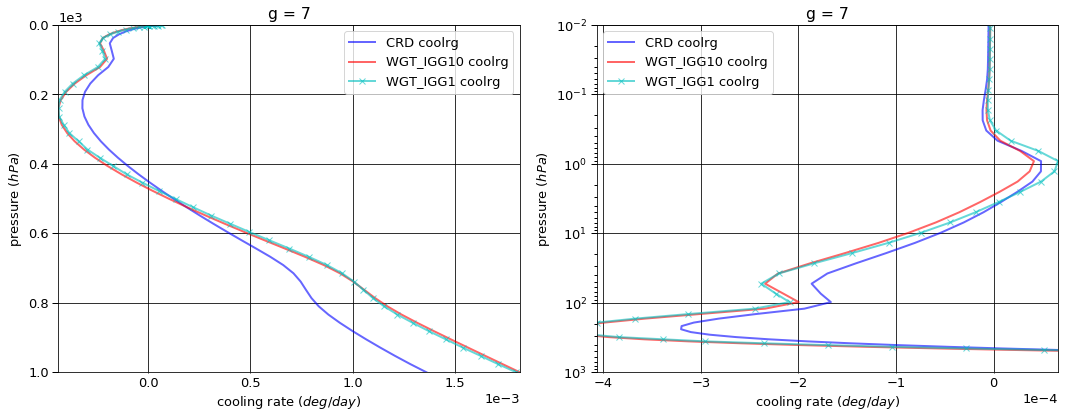

# Figure: cooling rate g-group 8

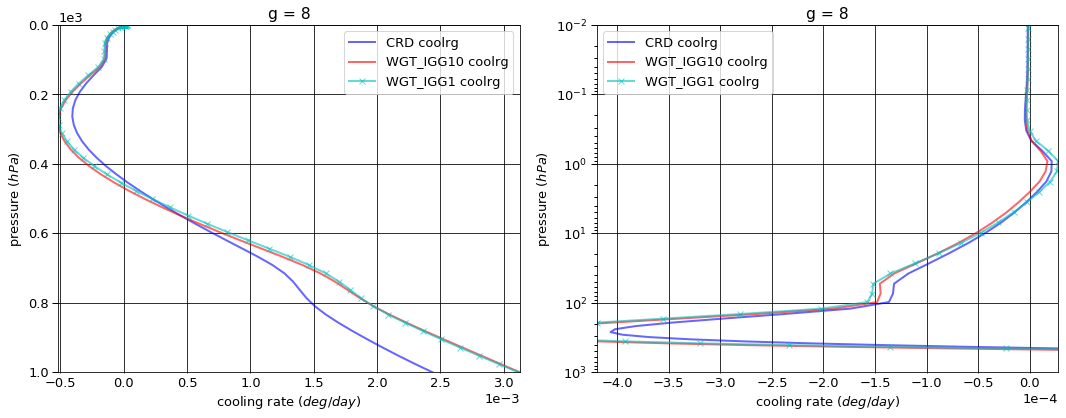

# Figure: cooling rate g-group 9

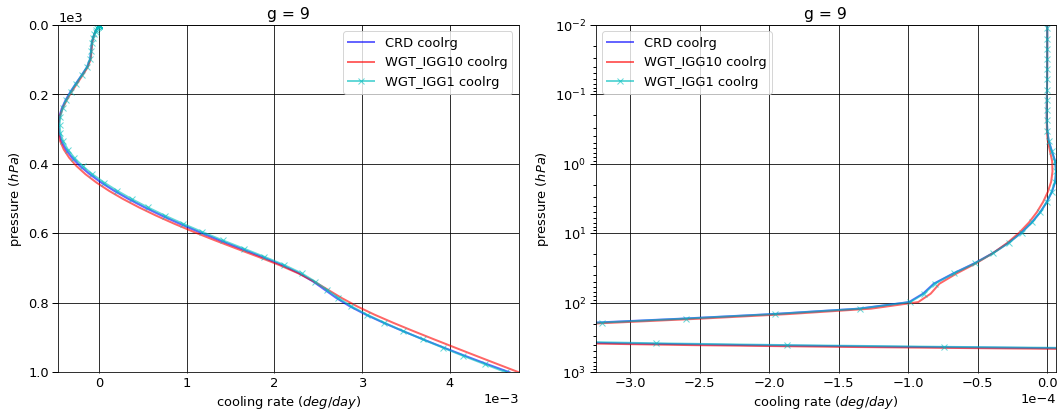

# Figure: cooling rate g-group 10

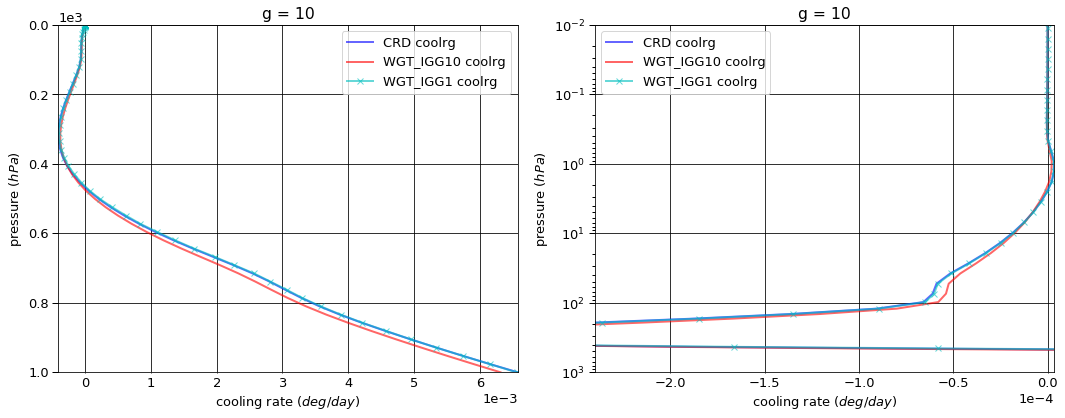

# Figure: cooling rate g-group 11

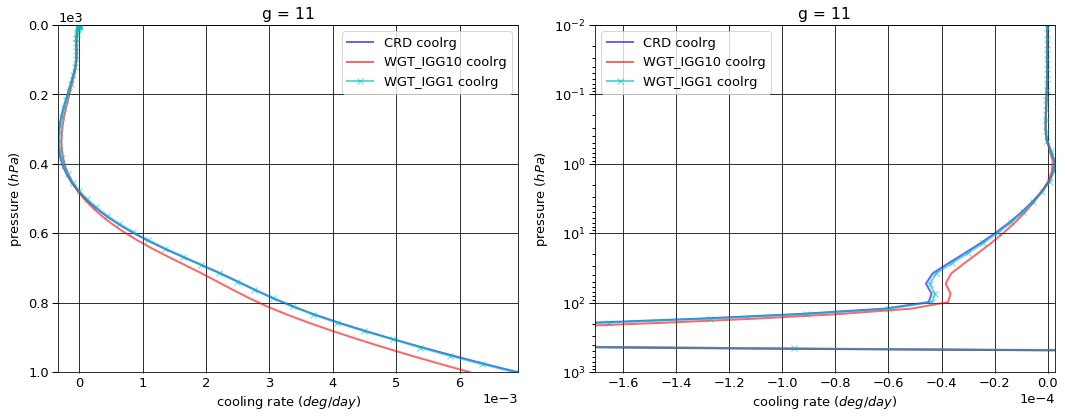

# Figure: cooling rate g-group 12

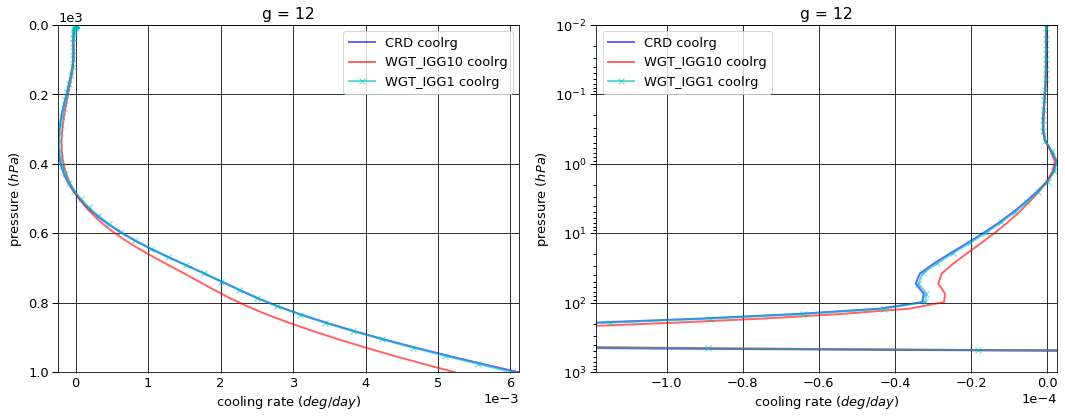

# Figure: cooling rate g-group 13

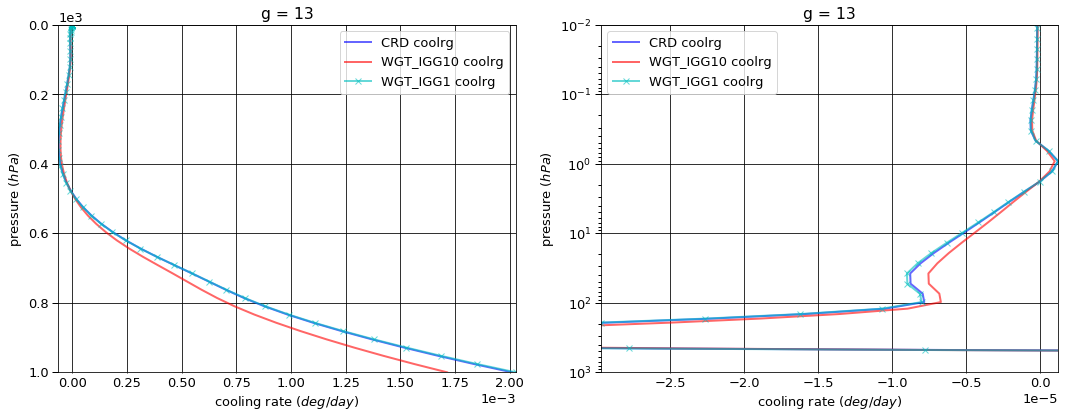

# Figure: cooling rate g-group 14

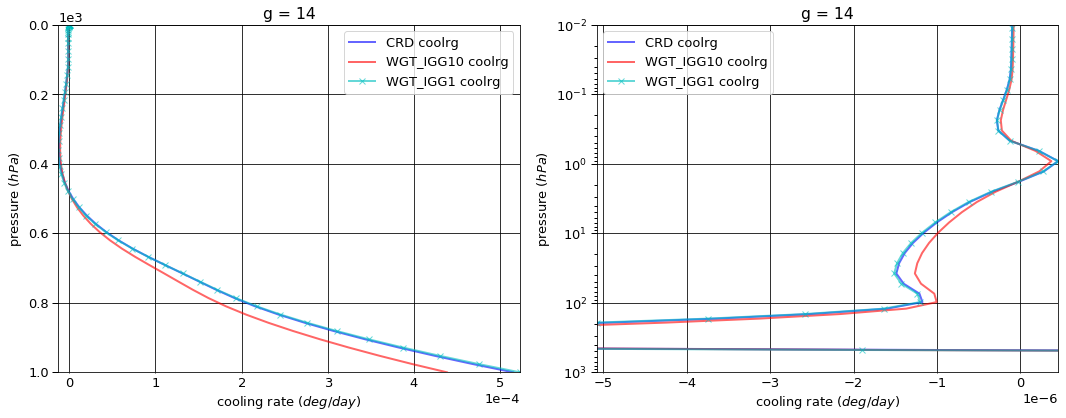

# Figure: cooling rate g-group 15

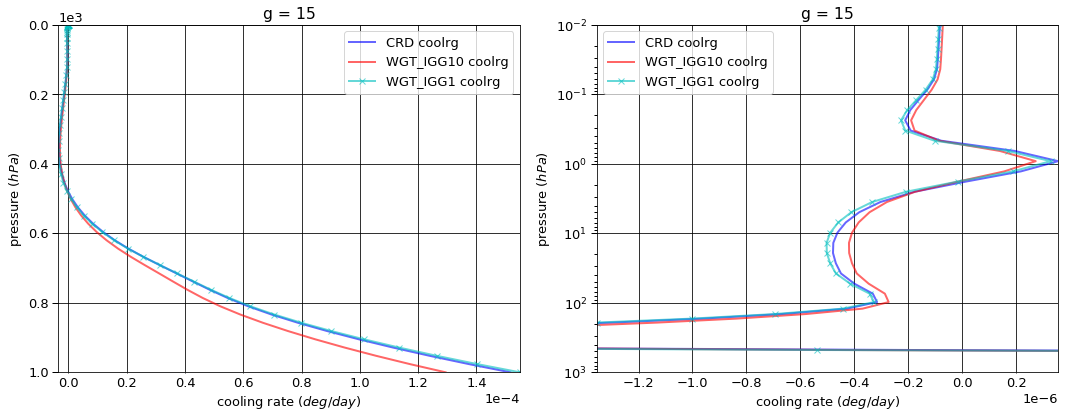

# Figure: cooling rate g-group 16

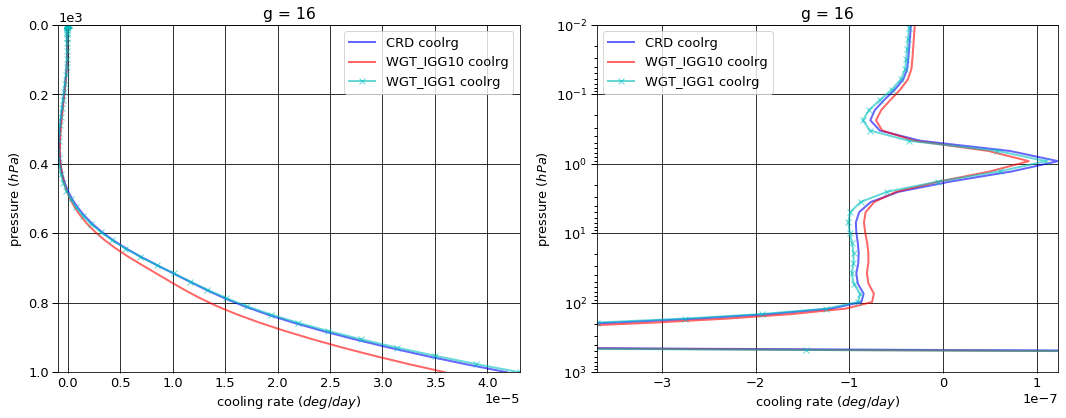

# Figure: cooling rate g-group total

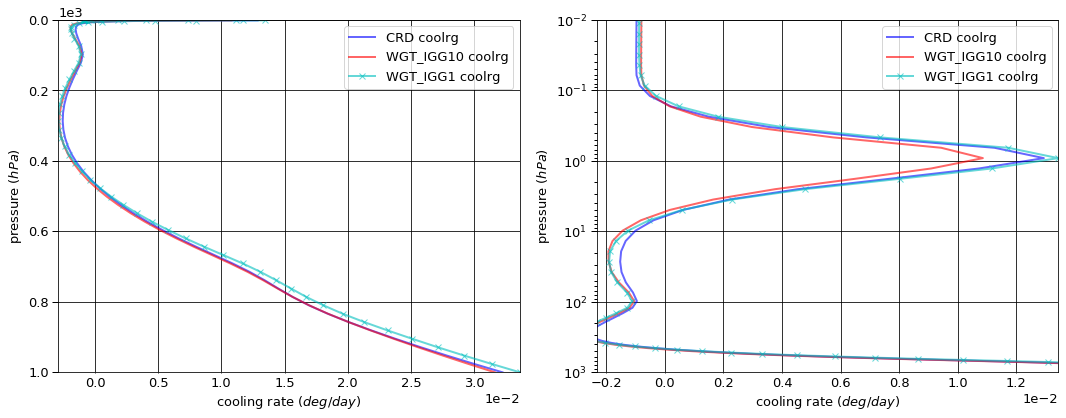

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.008470  0.000000 -0.008470
   1013.0   76    -0.017845  0.010158 -0.007687
2  0.0      1     -0.019749  0.000000 -0.019749
   1013.0   76    -0.028988  0.011038 -0.017950
3  0.0      1     -0.020551  0.000000 -0.020551
   1013.0   76    -0.025153  0.005759 -0.019393
4  0.0      1     -0.043725  0.000000 -0.043725
   1013.0   76    -0.051189  0.010780 -0.040409
5  0.0      1     -0.098176  0.000000 -0.098176
   1013.0   76    -0.115276  0.023305 -0.091972
6  0.0      1     -0.167990  0.000000 -0.167990
   1013.0   76    -0.194864  0.039012 -0.155851
7  0.0      1     -0.348483  0.000000 -0.348483
   1013.0   76    -0.403495  0.089914 -0.313581
8  0.0      1     -0.619843  0.000000 -0.619843
   1013.0   76    -0.699398  0.149356 -0.550042
9  0.0      1     -0.648631  0.000000 -0.648631
   1013.0   76    -0.757708  0.248336 -0.509372
10 0.0      1     -1.620748  0.000000 -1.620748
   1013.0   76    -1.721740  0.277253 -1.444487
11 0.0      1     -3.928765  0.000000 -3.928765
   1013.0   76    -4.011519  0.253166 -3.758352
12 0.0      1     -8.457589  0.000000 -8.457589
   1013.0   76    -8.520869  0.207270 -8.313599
13 0.0      1     -6.731771  0.000000 -6.731771
   1013.0   76    -6.750005  0.064671 -6.685335
14 0.0      1     -4.483962  0.000000 -4.483962
   1013.0   76    -4.488067  0.015749 -4.472319
15 0.0      1     -3.753894  0.000000 -3.753894
   1013.0   76    -3.755030  0.004508 -3.750522
16 0.0      1     -3.187194  0.000000 -3.187194
   1013.0   76    -3.187495  0.001227 -3.186269


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.007852  0.000000 -0.007852
   1013.0   76    -0.017367  0.010308 -0.007059
2  0.0      1     -0.019190  0.000000 -0.019190
   1013.0   76    -0.029009  0.011691 -0.017319
3  0.0      1     -0.019606  0.000000 -0.019606
   1013.0   76    -0.024729  0.006377 -0.018352
4  0.0      1     -0.041517  0.000000 -0.041517
   1013.0   76    -0.050054  0.012276 -0.037777
5  0.0      1     -0.092935  0.000000 -0.092935
   1013.0   76    -0.113616  0.029421 -0.084195
6  0.0      1     -0.159930  0.000000 -0.159930
   1013.0   76    -0.191861  0.049101 -0.142760
7  0.0      1     -0.335655  0.000000 -0.335655
   1013.0   76    -0.397064  0.106983 -0.290081
8  0.0      1     -0.605739  0.000000 -0.605739
   1013.0   76    -0.689823  0.170327 -0.519496
9  0.0      1     -0.640981  0.000000 -0.640981
   1013.0   76    -0.741567  0.241141 -0.500426
10 0.0      1     -1.605077  0.000000 -1.605077
   1013.0   76    -1.693910  0.254280 -1.439630
11 0.0      1     -3.867542  0.000000 -3.867542
   1013.0   76    -3.937003  0.219757 -3.717246
12 0.0      1     -8.331963  0.000000 -8.331963
   1013.0   76    -8.384005  0.174888 -8.209117
13 0.0      1     -6.773457  0.000000 -6.773457
   1013.0   76    -6.788885  0.054678 -6.734207
14 0.0      1     -4.548238  0.000000 -4.548238
   1013.0   76    -4.551750  0.013329 -4.538421
15 0.0      1     -3.834954  0.000000 -3.834954
   1013.0   76    -3.835936  0.003829 -3.832107
16 0.0      1     -3.281796  0.000000 -3.281796
   1013.0   76    -3.282061  0.001048 -3.281013


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.008224  0.000000 -0.008224
   1013.0   76    -0.017367  0.010126 -0.007241
2  0.0      1     -0.019210  0.000000 -0.019210
   1013.0   76    -0.029009  0.011751 -0.017258
3  0.0      1     -0.019378  0.000000 -0.019378
   1013.0   76    -0.024729  0.006642 -0.018087
4  0.0      1     -0.040999  0.000000 -0.040999
   1013.0   76    -0.050054  0.012859 -0.037195
5  0.0      1     -0.091746  0.000000 -0.091746
   1013.0   76    -0.113616  0.030684 -0.082932
6  0.0      1     -0.157939  0.000000 -0.157939
   1013.0   76    -0.191861  0.051272 -0.140589
7  0.0      1     -0.331761  0.000000 -0.331761
   1013.0   76    -0.397064  0.111338 -0.285727
8  0.0      1     -0.599451  0.000000 -0.599451
   1013.0   76    -0.689823  0.178617 -0.511206
9  0.0      1     -0.634919  0.000000 -0.634919
   1013.0   76    -0.741567  0.247669 -0.493898
10 0.0      1     -1.594781  0.000000 -1.594781
   1013.0   76    -1.693910  0.276723 -1.417188
11 0.0      1     -3.856476  0.000000 -3.856476
   1013.0   76    -3.937003  0.251067 -3.685936
12 0.0      1     -8.322430  0.000000 -8.322430
   1013.0   76    -8.384005  0.205310 -8.178695
13 0.0      1     -6.770479  0.000000 -6.770479
   1013.0   76    -6.788885  0.065050 -6.723835
14 0.0      1     -4.547547  0.000000 -4.547547
   1013.0   76    -4.551750  0.015935 -4.535815
15 0.0      1     -3.834759  0.000000 -3.834759
   1013.0   76    -3.835936  0.004586 -3.831350
16 0.0      1     -3.281743  0.000000 -3.281743
   1013.0   76    -3.282061  0.001256 -3.280805


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000618  0.000000  0.000618
   1013.0   76     0.000478  0.000150  0.000627
2  0.0      1      0.000559  0.000000  0.000559
   1013.0   76    -0.000021  0.000653  0.000632
3  0.0      1      0.000945  0.000000  0.000945
   1013.0   76     0.000424  0.000618  0.001042
4  0.0      1      0.002208  0.000000  0.002208
   1013.0   76     0.001135  0.001497  0.002632
5  0.0      1      0.005241  0.000000  0.005241
   1013.0   76     0.001660  0.006116  0.007776
6  0.0      1      0.008060  0.000000  0.008060
   1013.0   76     0.003003  0.010089  0.013092
7  0.0      1      0.012828  0.000000  0.012828
   1013.0   76     0.006431  0.017069  0.023499
8  0.0      1      0.014104  0.000000  0.014104
   1013.0   76     0.009575  0.020971  0.030546
9  0.0      1      0.007650  0.000000  0.007650
   1013.0   76     0.016141 -0.007195  0.008946
10 0.0      1      0.015672  0.000000  0.015672
   1013.0   76     0.027830 -0.022973  0.004858
11 0.0      1      0.061223  0.000000  0.061223
   1013.0   76     0.074515 -0.033409  0.041106
12 0.0      1      0.125626  0.000000  0.125626
   1013.0   76     0.136864 -0.032383  0.104481
13 0.0      1     -0.041686  0.000000 -0.041686
   1013.0   76    -0.038880 -0.009992 -0.048872
14 0.0      1     -0.064276  0.000000 -0.064276
   1013.0   76    -0.063683 -0.002420 -0.066103
15 0.0      1     -0.081060  0.000000 -0.081060
   1013.0   76    -0.080906 -0.000679 -0.081585
16 0.0      1     -0.094602  0.000000 -0.094602
   1013.0   76    -0.094565 -0.000179 -0.094744


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000246  0.000000  0.000246
   1013.0   76     0.000478 -0.000032  0.000445
2  0.0      1      0.000539  0.000000  0.000539
   1013.0   76    -0.000021  0.000714  0.000693
3  0.0      1      0.001173  0.000000  0.001173
   1013.0   76     0.000424  0.000883  0.001307
4  0.0      1      0.002726  0.000000  0.002726
   1013.0   76     0.001135  0.002079  0.003214
5  0.0      1      0.006430  0.000000  0.006430
   1013.0   76     0.001660  0.007379  0.009039
6  0.0      1      0.010052  0.000000  0.010052
   1013.0   76     0.003003  0.012260  0.015263
7  0.0      1      0.016722  0.000000  0.016722
   1013.0   76     0.006431  0.021424  0.027854
8  0.0      1      0.020392  0.000000  0.020392
   1013.0   76     0.009575  0.029261  0.038836
9  0.0      1      0.013712  0.000000  0.013712
   1013.0   76     0.016141 -0.000667  0.015474
10 0.0      1      0.025967  0.000000  0.025967
   1013.0   76     0.027830 -0.000530  0.027300
11 0.0      1      0.072289  0.000000  0.072289
   1013.0   76     0.074515 -0.002099  0.072416
12 0.0      1      0.135159  0.000000  0.135159
   1013.0   76     0.136864 -0.001960  0.134904
13 0.0      1     -0.038708  0.000000 -0.038708
   1013.0   76    -0.038880  0.000379 -0.038501
14 0.0      1     -0.063585  0.000000 -0.063585
   1013.0   76    -0.063683  0.000186 -0.063497
15 0.0      1     -0.080866  0.000000 -0.080866
   1013.0   76    -0.080906  0.000078 -0.080828
16 0.0      1     -0.094549  0.000000 -0.094549
   1013.0   76    -0.094565  0.000029 -0.094536

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.451282e-04
   1001.112500 75     1.120631e-04
2  0.000312    1     -2.301414e-04
   1001.112500 75     1.437467e-04
3  0.000312    1     -5.763274e-05
   1001.112500 75     8.253848e-05
4  0.000312    1     -3.585907e-05
   1001.112500 75     1.725156e-04
5  0.000312    1     -2.936976e-05
   1001.112500 75     3.357950e-04
6  0.000312    1     -9.653670e-06
   1001.112500 75     5.692972e-04
7  0.000312    1     -4.091758e-06
   1001.112500 75     1.359682e-03
8  0.000312    1     -1.443395e-06
   1001.112500 75     2.439112e-03
9  0.000312    1     -6.595477e-09
   1001.112500 75     4.684014e-03
10 0.000312    1     -2.942598e-08
   1001.112500 75     6.577818e-03
11 0.000312    1     -8.397300e-08
   1001.112500 75     6.923058e-03
12 0.000312    1     -1.888882e-07
   1001.112500 75     6.121354e-03
13 0.000312    1     -1.448183e-07
   1001.112500 75     2.011178e-03
14 0.000312    1     -7.597558e-08
   1001.112500 75     5.152362e-04
15 0.000312    1     -6.618293e-08
   1001.112500 75     1.515963e-04
16 0.000312    1     -2.803903e-08
   1001.112500 75     4.188686e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -4.287922e-04
   1001.112500 75     1.149060e-04
2  0.000312    1     -2.186324e-04
   1001.112500 75     1.610328e-04
3  0.000312    1     -5.201890e-05
   1001.112500 75     9.860502e-05
4  0.000312    1     -2.715391e-05
   1001.112500 75     2.090016e-04
5  0.000312    1     -2.002291e-05
   1001.112500 75     4.765078e-04
6  0.000312    1     -6.490213e-06
   1001.112500 75     8.056553e-04
7  0.000312    1     -2.760598e-06
   1001.112500 75     1.815433e-03
8  0.000312    1     -1.060739e-06
   1001.112500 75     3.127775e-03
9  0.000312    1     -5.900505e-09
   1001.112500 75     4.789746e-03
10 0.000312    1     -2.531619e-08
   1001.112500 75     6.315302e-03
11 0.000312    1     -6.882472e-08
   1001.112500 75     6.166384e-03
12 0.000312    1     -1.537524e-07
   1001.112500 75     5.236514e-03
13 0.000312    1     -1.194931e-07
   1001.112500 75     1.714097e-03
14 0.000312    1     -6.152977e-08
   1001.112500 75     4.383353e-04
15 0.000312    1     -5.751304e-08
   1001.112500 75     1.293950e-04
16 0.000312    1     -2.458669e-08
   1001.112500 75     3.597796e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -5.190139e-04
   1001.112500 75     1.085835e-04
2  0.000312    1     -2.153128e-04
   1001.112500 75     1.557715e-04
3  0.000312    1     -5.140359e-05
   1001.112500 75     9.826637e-05
4  0.000312    1     -2.704561e-05
   1001.112500 75     2.084422e-04
5  0.000312    1     -1.973919e-05
   1001.112500 75     4.745558e-04
6  0.000312    1     -6.456628e-06
   1001.112500 75     8.026185e-04
7  0.000312    1     -2.793294e-06
   1001.112500 75     1.798401e-03
8  0.000312    1     -1.104172e-06
   1001.112500 75     3.116547e-03
9  0.000312    1     -6.143671e-09
   1001.112500 75     4.644285e-03
10 0.000312    1     -2.810808e-08
   1001.112500 75     6.559916e-03
11 0.000312    1     -7.966208e-08
   1001.112500 75     6.876950e-03
12 0.000312    1     -1.816353e-07
   1001.112500 75     6.020820e-03
13 0.000312    1     -1.425368e-07
   1001.112500 75     2.027592e-03
14 0.000312    1     -7.363399e-08
   1001.112500 75     5.229696e-04
15 0.000312    1     -6.887876e-08
   1001.112500 75     1.548673e-04
16 0.000312    1     -2.948602e-08
   1001.112500 75     4.310794e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.163360e-04
   1001.112500 75     2.842870e-06
2  0.000312    1      1.150901e-05
   1001.112500 75     1.728616e-05
3  0.000312    1      5.613841e-06
   1001.112500 75     1.606654e-05
4  0.000312    1      8.705160e-06
   1001.112500 75     3.648604e-05
5  0.000312    1      9.346842e-06
   1001.112500 75     1.407129e-04
6  0.000312    1      3.163457e-06
   1001.112500 75     2.363581e-04
7  0.000312    1      1.331160e-06
   1001.112500 75     4.557509e-04
8  0.000312    1      3.826562e-07
   1001.112500 75     6.886635e-04
9  0.000312    1      6.949718e-10
   1001.112500 75     1.057314e-04
10 0.000312    1      4.109790e-09
   1001.112500 75    -2.625161e-04
11 0.000312    1      1.514828e-08
   1001.112500 75    -7.566739e-04
12 0.000312    1      3.513586e-08
   1001.112500 75    -8.848405e-04
13 0.000312    1      2.532519e-08
   1001.112500 75    -2.970810e-04
14 0.000312    1      1.444581e-08
   1001.112500 75    -7.690095e-05
15 0.000312    1      8.669886e-09
   1001.112500 75    -2.220136e-05
16 0.000312    1      3.452343e-09
   1001.112500 75    -5.908896e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.611431e-05
   1001.112500 75    -3.479620e-06
2  0.000312    1      1.482860e-05
   1001.112500 75     1.202484e-05
3  0.000312    1      6.229158e-06
   1001.112500 75     1.572789e-05
4  0.000312    1      8.813466e-06
   1001.112500 75     3.592666e-05
5  0.000312    1      9.630570e-06
   1001.112500 75     1.387609e-04
6  0.000312    1      3.197042e-06
   1001.112500 75     2.333214e-04
7  0.000312    1      1.298465e-06
   1001.112500 75     4.387189e-04
8  0.000312    1      3.392227e-07
   1001.112500 75     6.774350e-04
9  0.000312    1      4.518067e-10
   1001.112500 75    -3.972910e-05
10 0.000312    1      1.317895e-09
   1001.112500 75    -1.790230e-05
11 0.000312    1      4.310927e-09
   1001.112500 75    -4.610810e-05
12 0.000312    1      7.252930e-09
   1001.112500 75    -1.005346e-04
13 0.000312    1      2.281550e-09
   1001.112500 75     1.641420e-05
14 0.000312    1      2.341590e-09
   1001.112500 75     7.733360e-06
15 0.000312    1     -2.695830e-09
   1001.112500 75     3.270940e-06
16 0.000312    1     -1.446982e-09
   1001.112500 75     1.221089e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.139541,0.000000,-34.139541
1013.0,76,-34.728642,1.411502,-33.317140



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.166431,0.000000,-34.166431
1013.0,76,-34.728642,1.359436,-33.369206



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.111843,0.000000,-34.111843
1013.0,76,-34.728642,1.480886,-33.247757



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.688985e-02,0.000000,-0.026890
1013.0,76,5.400001e-08,-0.052066,-0.052066



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.769797e-02,0.000000,0.027698
1013.0,76,5.400001e-08,0.069383,0.069383


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000914
1001.112500,75,0.032241



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000757
1001.112500,75,0.031635



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000843
1001.112500,75,0.033614



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000156
1001.112500,75,-0.000606



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000070
1001.112500,75,0.001373


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000542,0.000500
2,0.000833,0.000835
3,0.000750,0.000712
4,0.001542,0.001441
5,0.003417,0.003272
6,0.005792,0.005525
7,0.012000,0.011433
8,0.020708,0.019863
9,0.022750,0.021353


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.625183e-21
2,4.593142e-22
3,1.298128e-22
4,3.668809e-23
5,1.036890e-23
6,2.930491e-24
7,8.282244e-25
8,2.340754e-25
9,1.618833e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.625183e-21,NaN,0.000542,0.000500,0.000542,0.000500,1.0
2,4.593142e-22,0.282623,0.000833,0.000835,0.001375,0.001335,1.0
3,1.298128e-22,0.282623,0.000750,0.000712,0.002125,0.002047,1.0
4,3.668809e-23,0.282623,0.001542,0.001441,0.003667,0.003489,1.0
5,1.036890e-23,0.282623,0.003417,0.003272,0.007083,0.006760,1.0
6,2.930491e-24,0.282623,0.005792,0.005525,0.012875,0.012285,1.0
7,8.282244e-25,0.282623,0.012000,0.011433,0.024875,0.023718,1.0
8,2.340754e-25,0.282623,0.020708,0.019863,0.045583,0.043581,1.0
9,1.618833e-23,69.158615,0.022750,0.021353,0.068333,0.064935,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
